#Pear line elements

Using Bayesian Gaussian process latent variable model to discover a latent space representation of the line elements of a pear.

Made by Ivan De Boi (ivan.deboi at uantwerpen.be, http://www.InViLab.be).

In [141]:
shape_name_string = 'Pear'

# Imports

In [142]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

!pip install GPy
import GPy
from GPy.util import pca
from GPy import kern
GPy.plotting.change_plotting_library('matplotlib')

from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from numpy import genfromtxt

from google.colab import drive
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
#use this to adjust the resolution of the pictures etc.
#print(plt.rcParams)  # it will tell you all default setting in Matplotlib
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = [8,6]
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('figure.dpi'))
plt.rcParams['figure.dpi'] = 72.0*5
print(plt.rcParams.get('figure.dpi'))

[6.0, 4.0]
[8.0, 6.0]
72.0
360.0


# Data

In [144]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PhD 3D Sensing/05 GPLVM on set of lines/Line Elements Surface/Line Elements/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [145]:
data = genfromtxt(root_path + shape_name_string + ' line elements.csv', delimiter=',')
shape_name_string
Y = data[:,:]
print(Y[0:3,:])
print(Y.shape)

[[ 0.18022701  0.97661811 -0.11719723  0.58664125 -0.1079234   0.00280426
   0.7180438 ]
 [ 0.13780914  0.98485655 -0.105197    0.59337795 -0.08243386  0.00558362
   0.71014214]
 [ 0.17740339  0.98172879 -0.06882308  0.57995707 -0.10446509  0.00479449
   0.68894935]]
(6356, 7)


# PCA

In [146]:
# Normalize
scaler = StandardScaler()
scaler.fit(Y)

Yn = scaler.transform(Y)
print(Yn[0:3, :])

# Sanity checks
print("mean y:",Y.mean())
print("std y:", Y.std())
print("mean yn:", Yn.mean())
print("std yn:", Yn.std())

[[ 0.24138035  1.49321432 -0.93409869  1.72783504 -0.32261201  0.03797703
   1.33072831]
 [ 0.17984738  1.50594847 -0.89242184  1.74778095 -0.25202534  0.07652255
   1.28677556]
 [ 0.23728429  1.5011139  -0.76609512  1.70804461 -0.31303511  0.06557842
   1.16889142]]
mean y: 0.09524093882934313
std y: 0.45479028479354977
mean yn: -2.044175810871456e-17
std yn: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

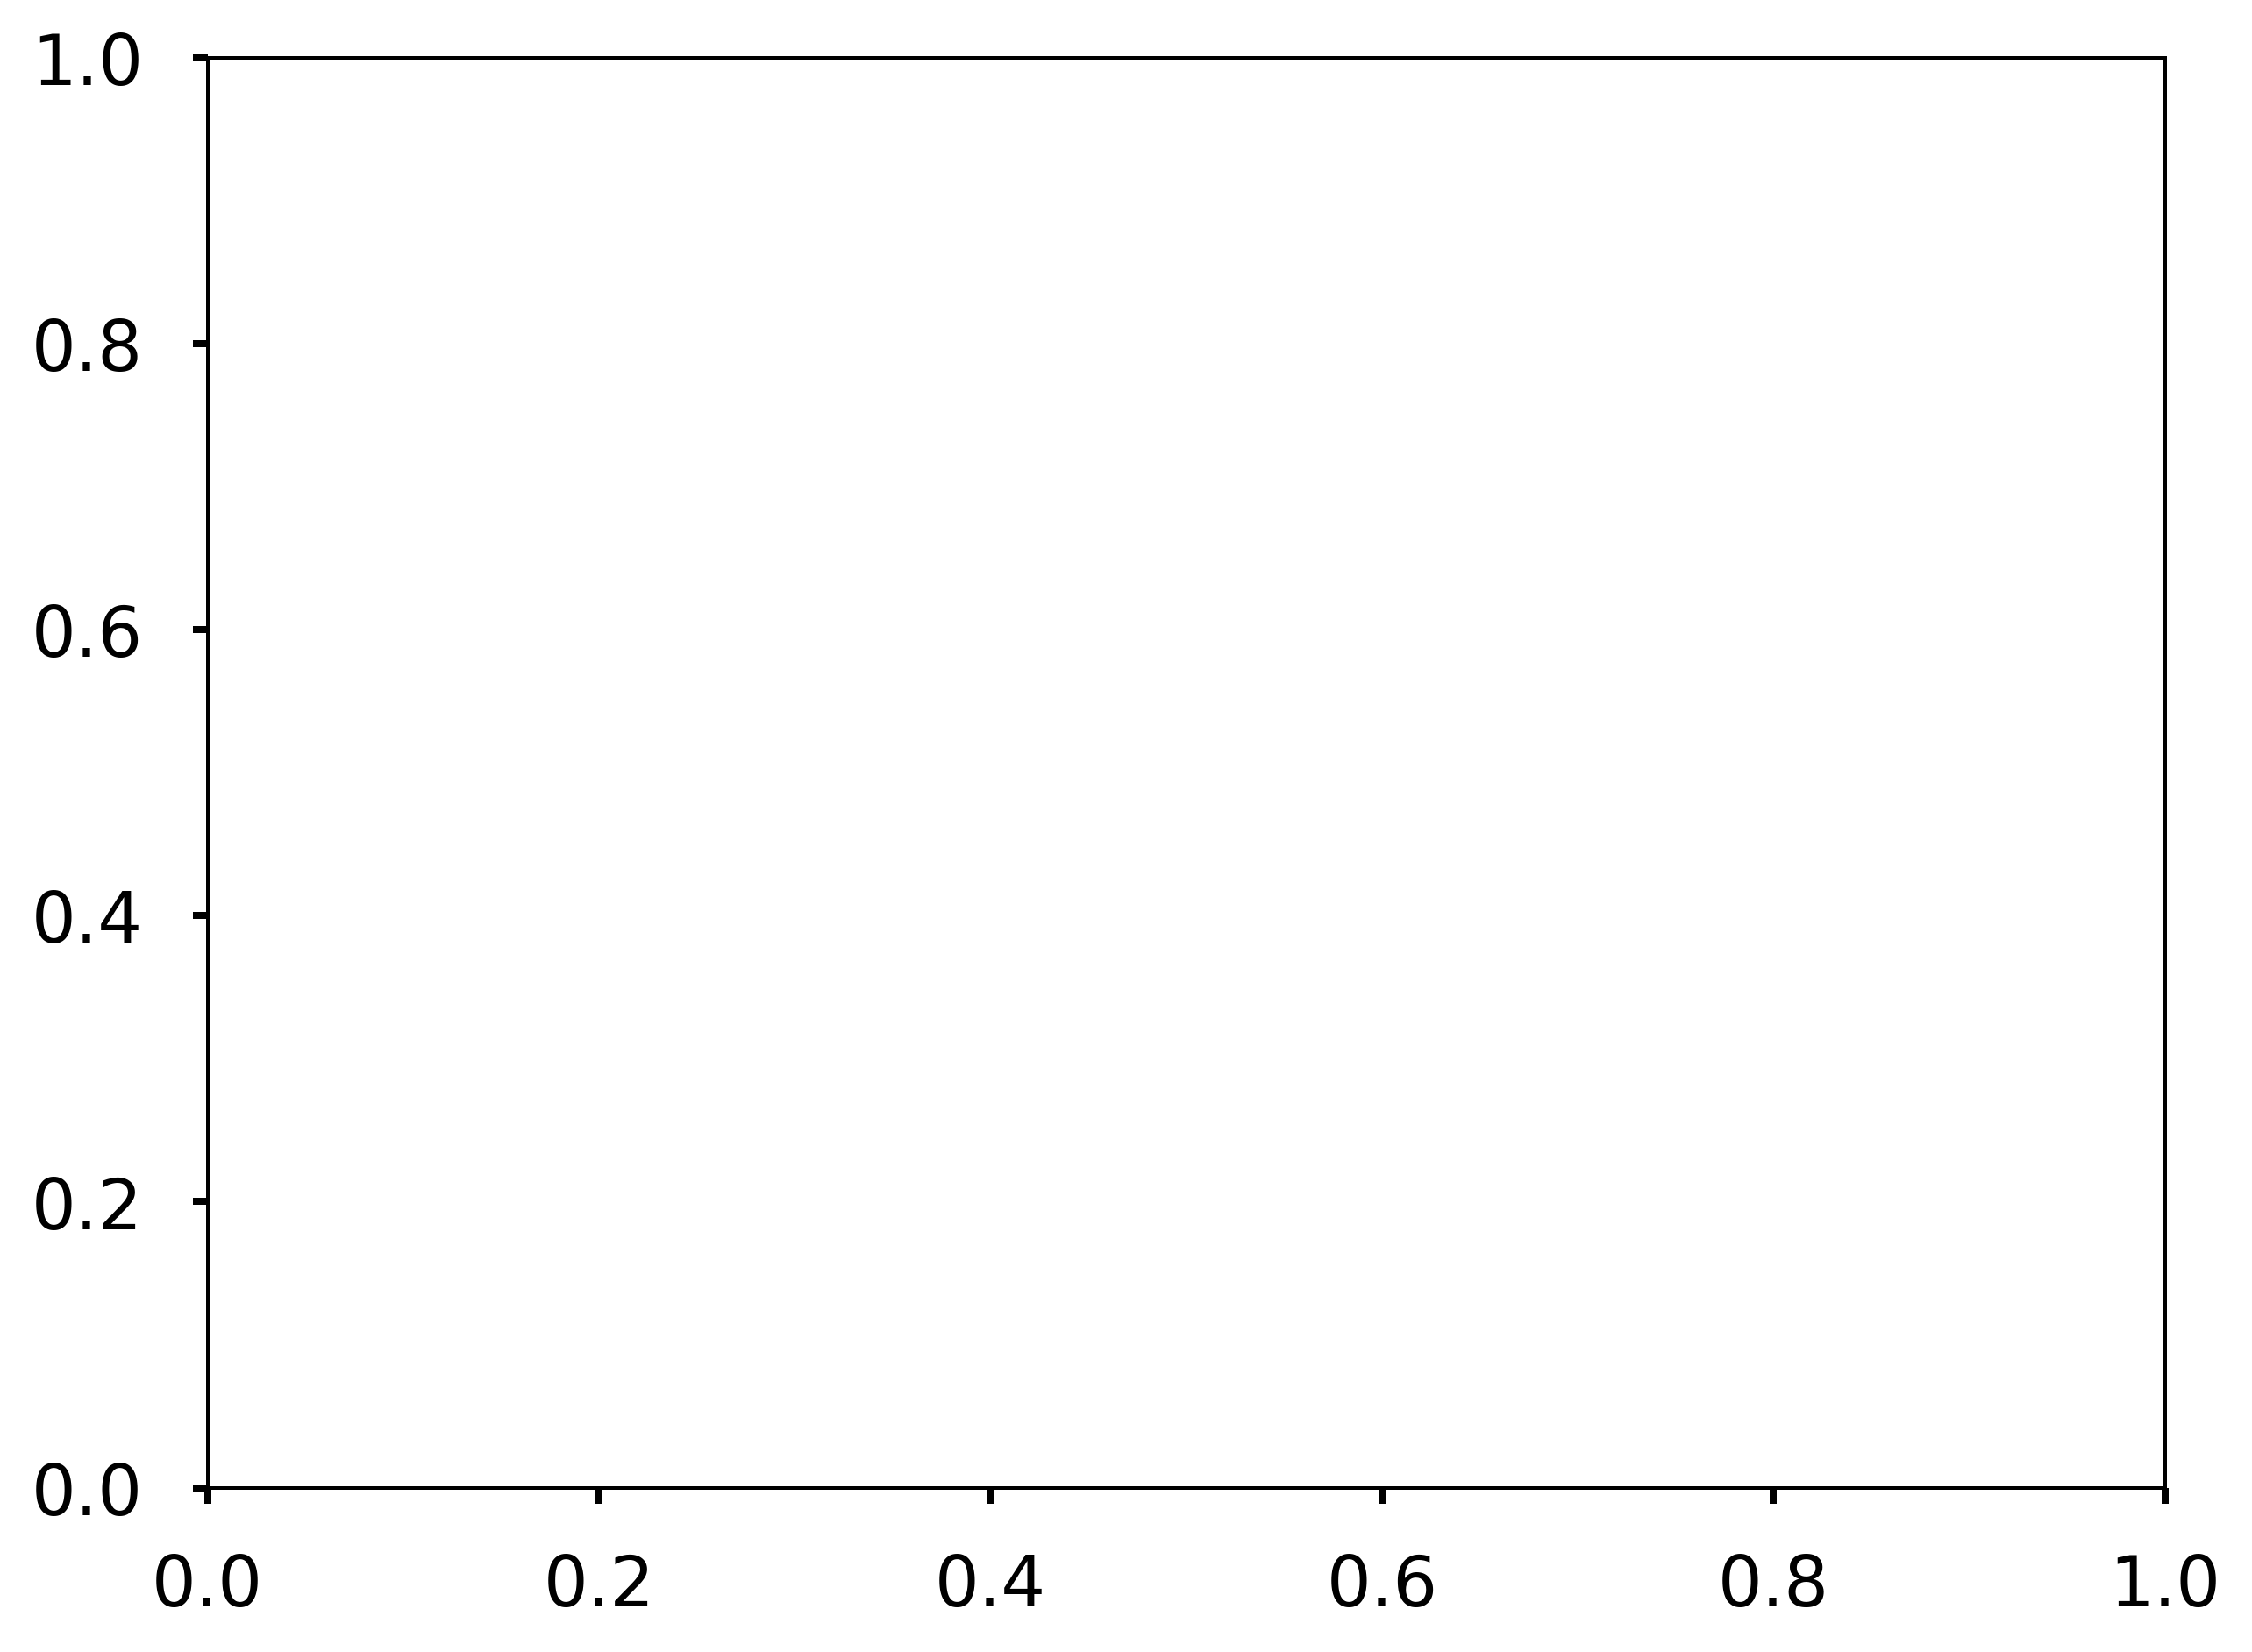

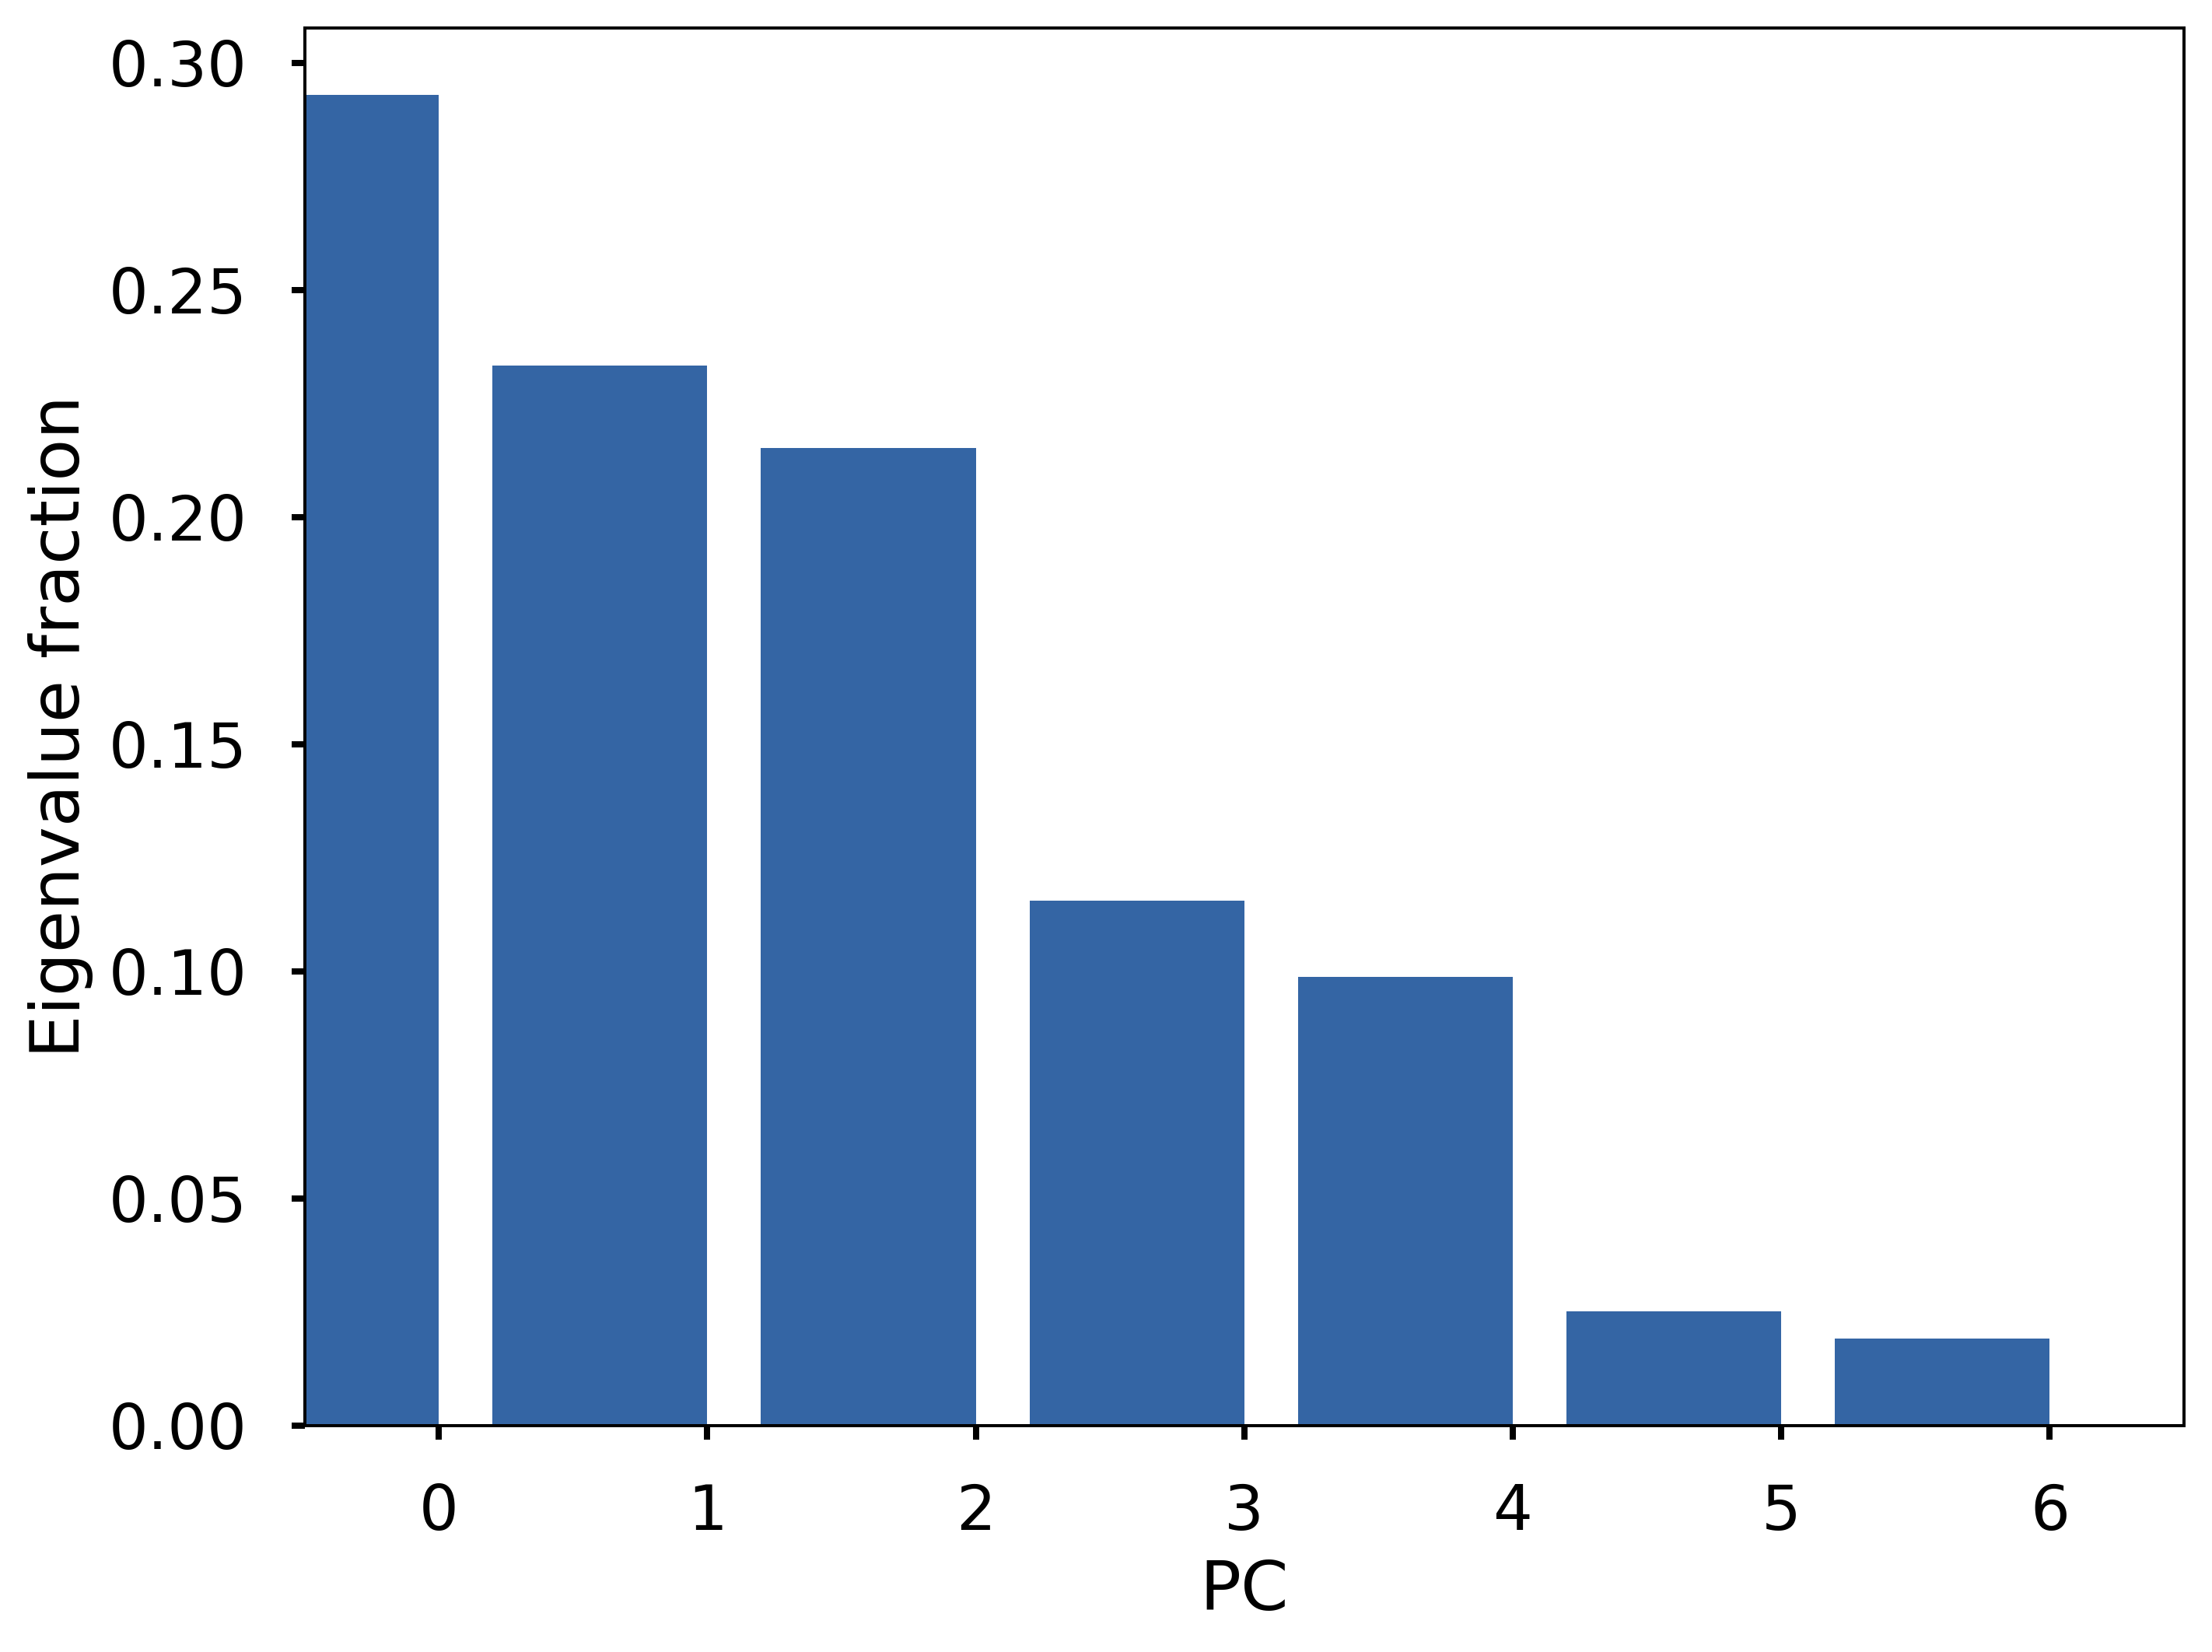

In [147]:
p = pca.PCA(Yn)
# plot first xxx eigenvalue fractions

fig, ax = plt.subplots()
p.plot_fracs(Yn.shape[1]) 

filename = shape_name_string + ' PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

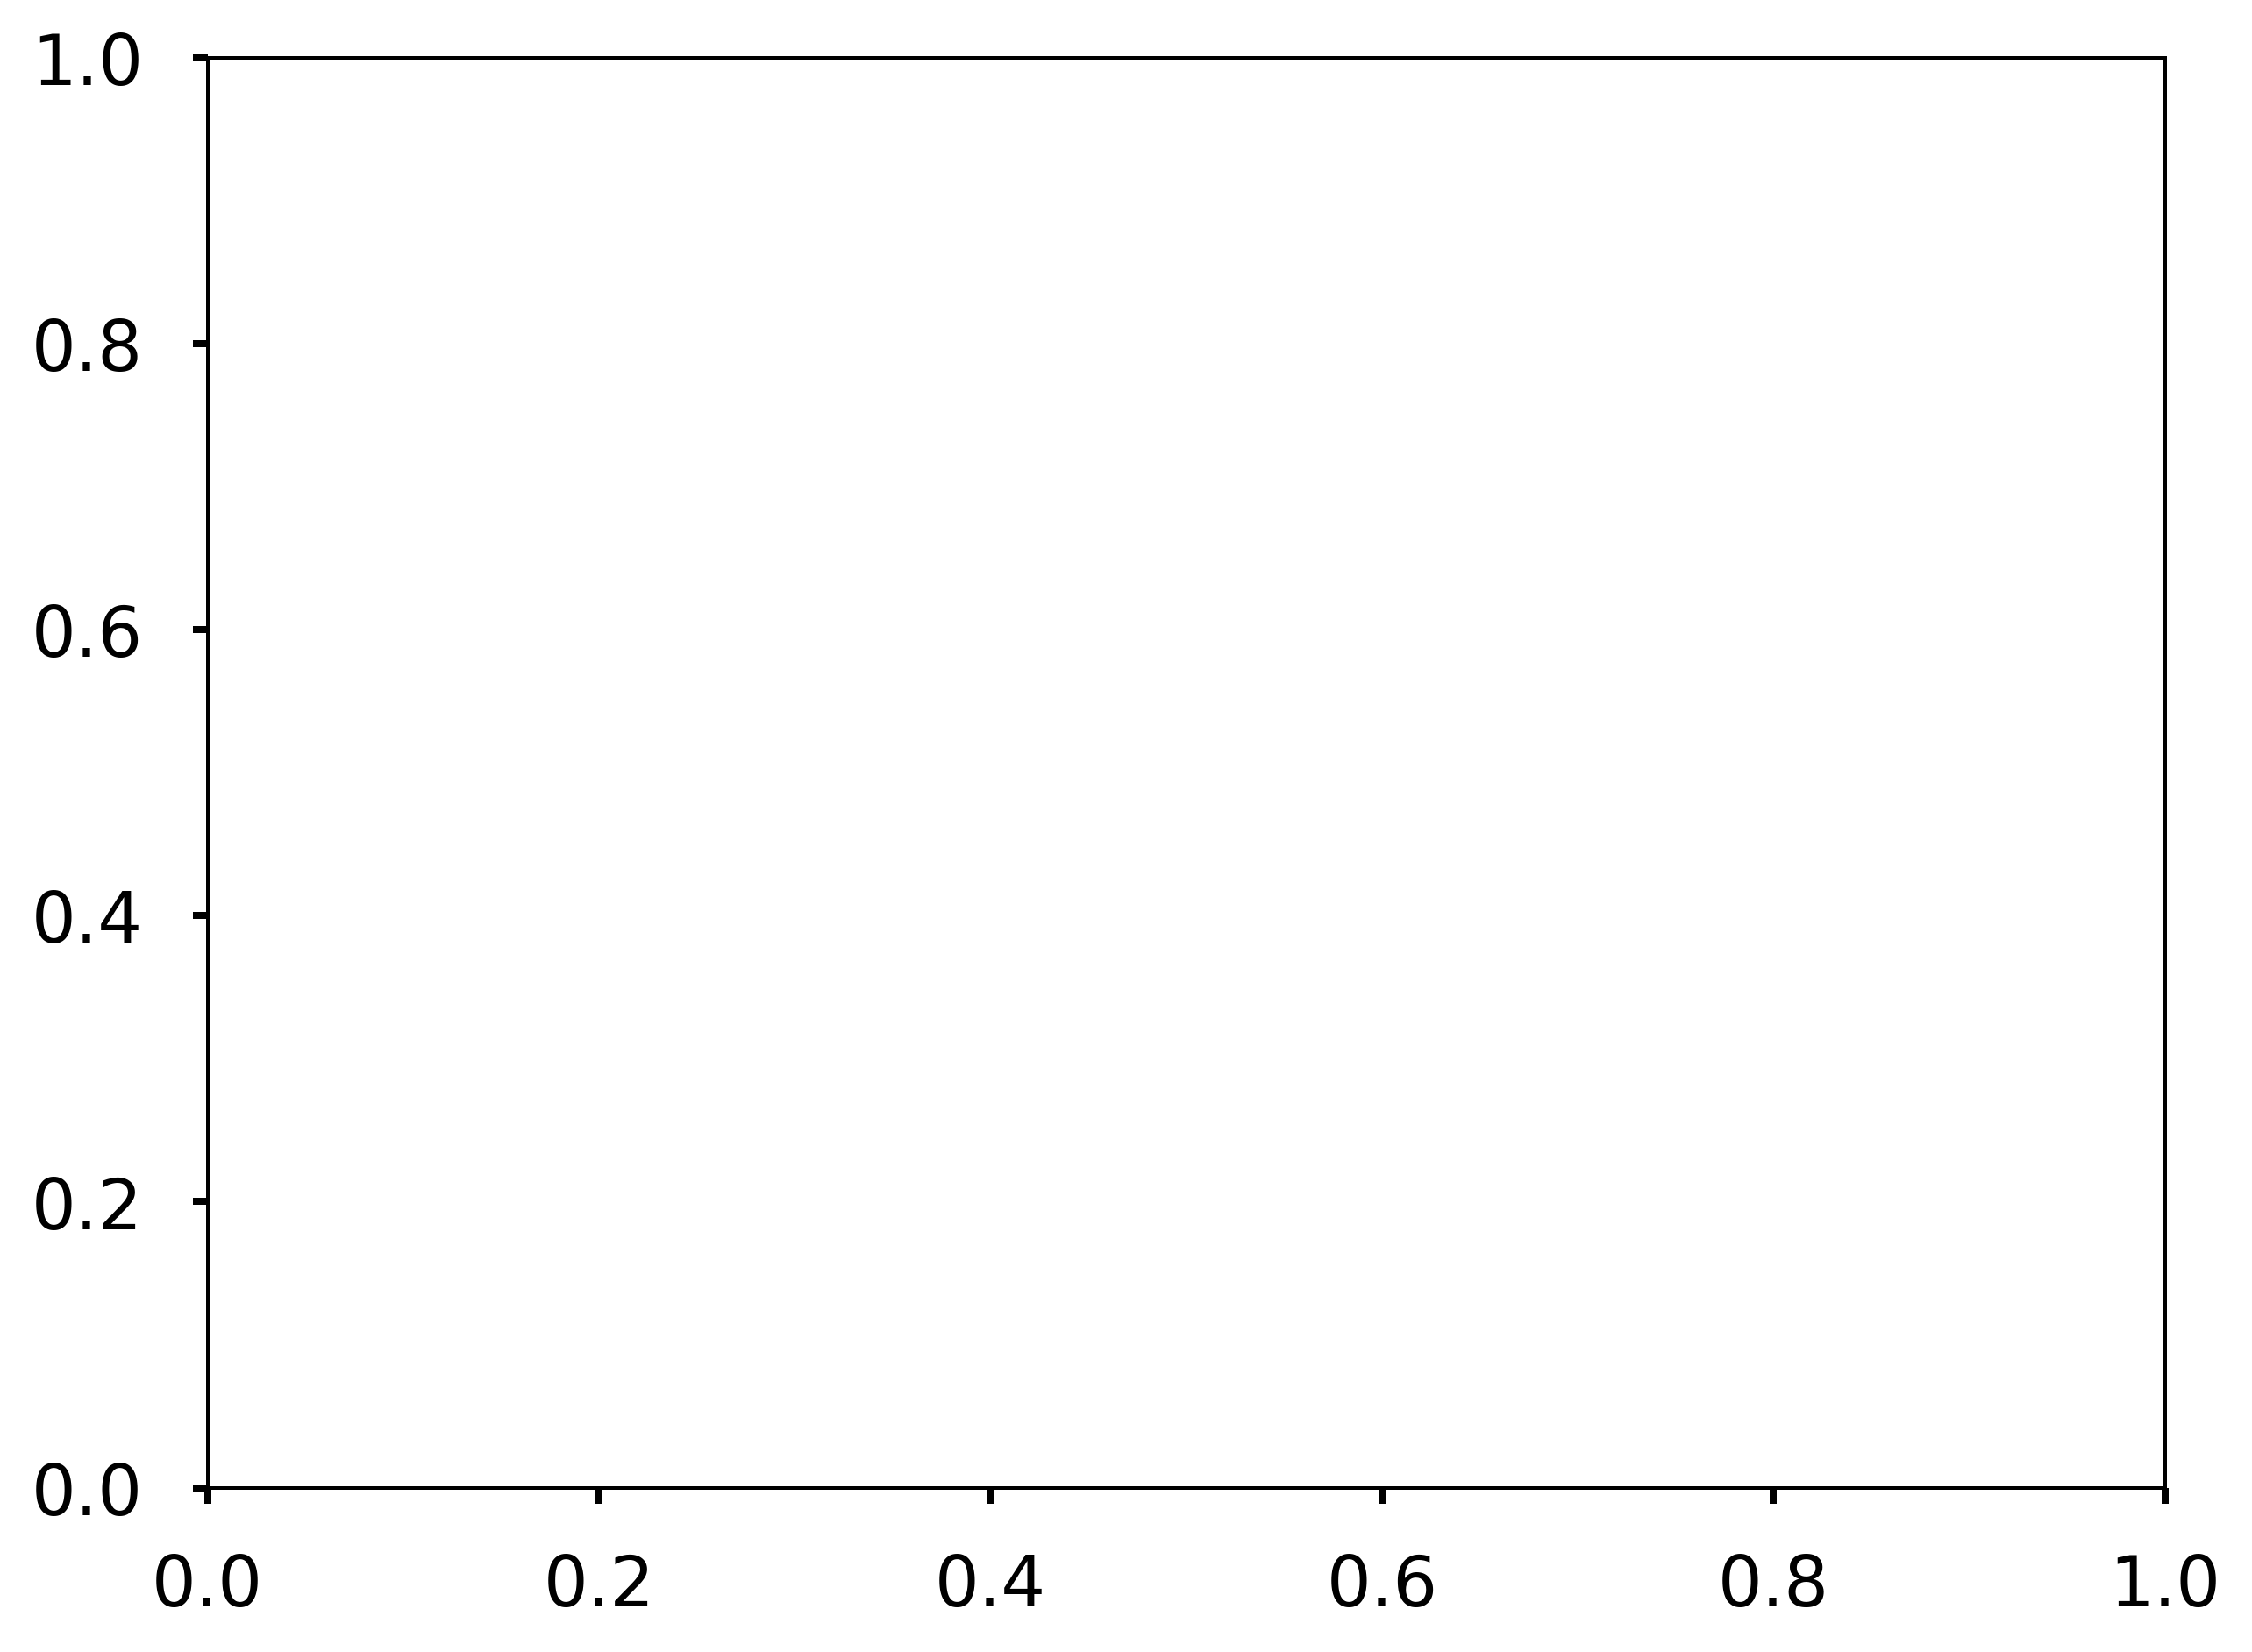

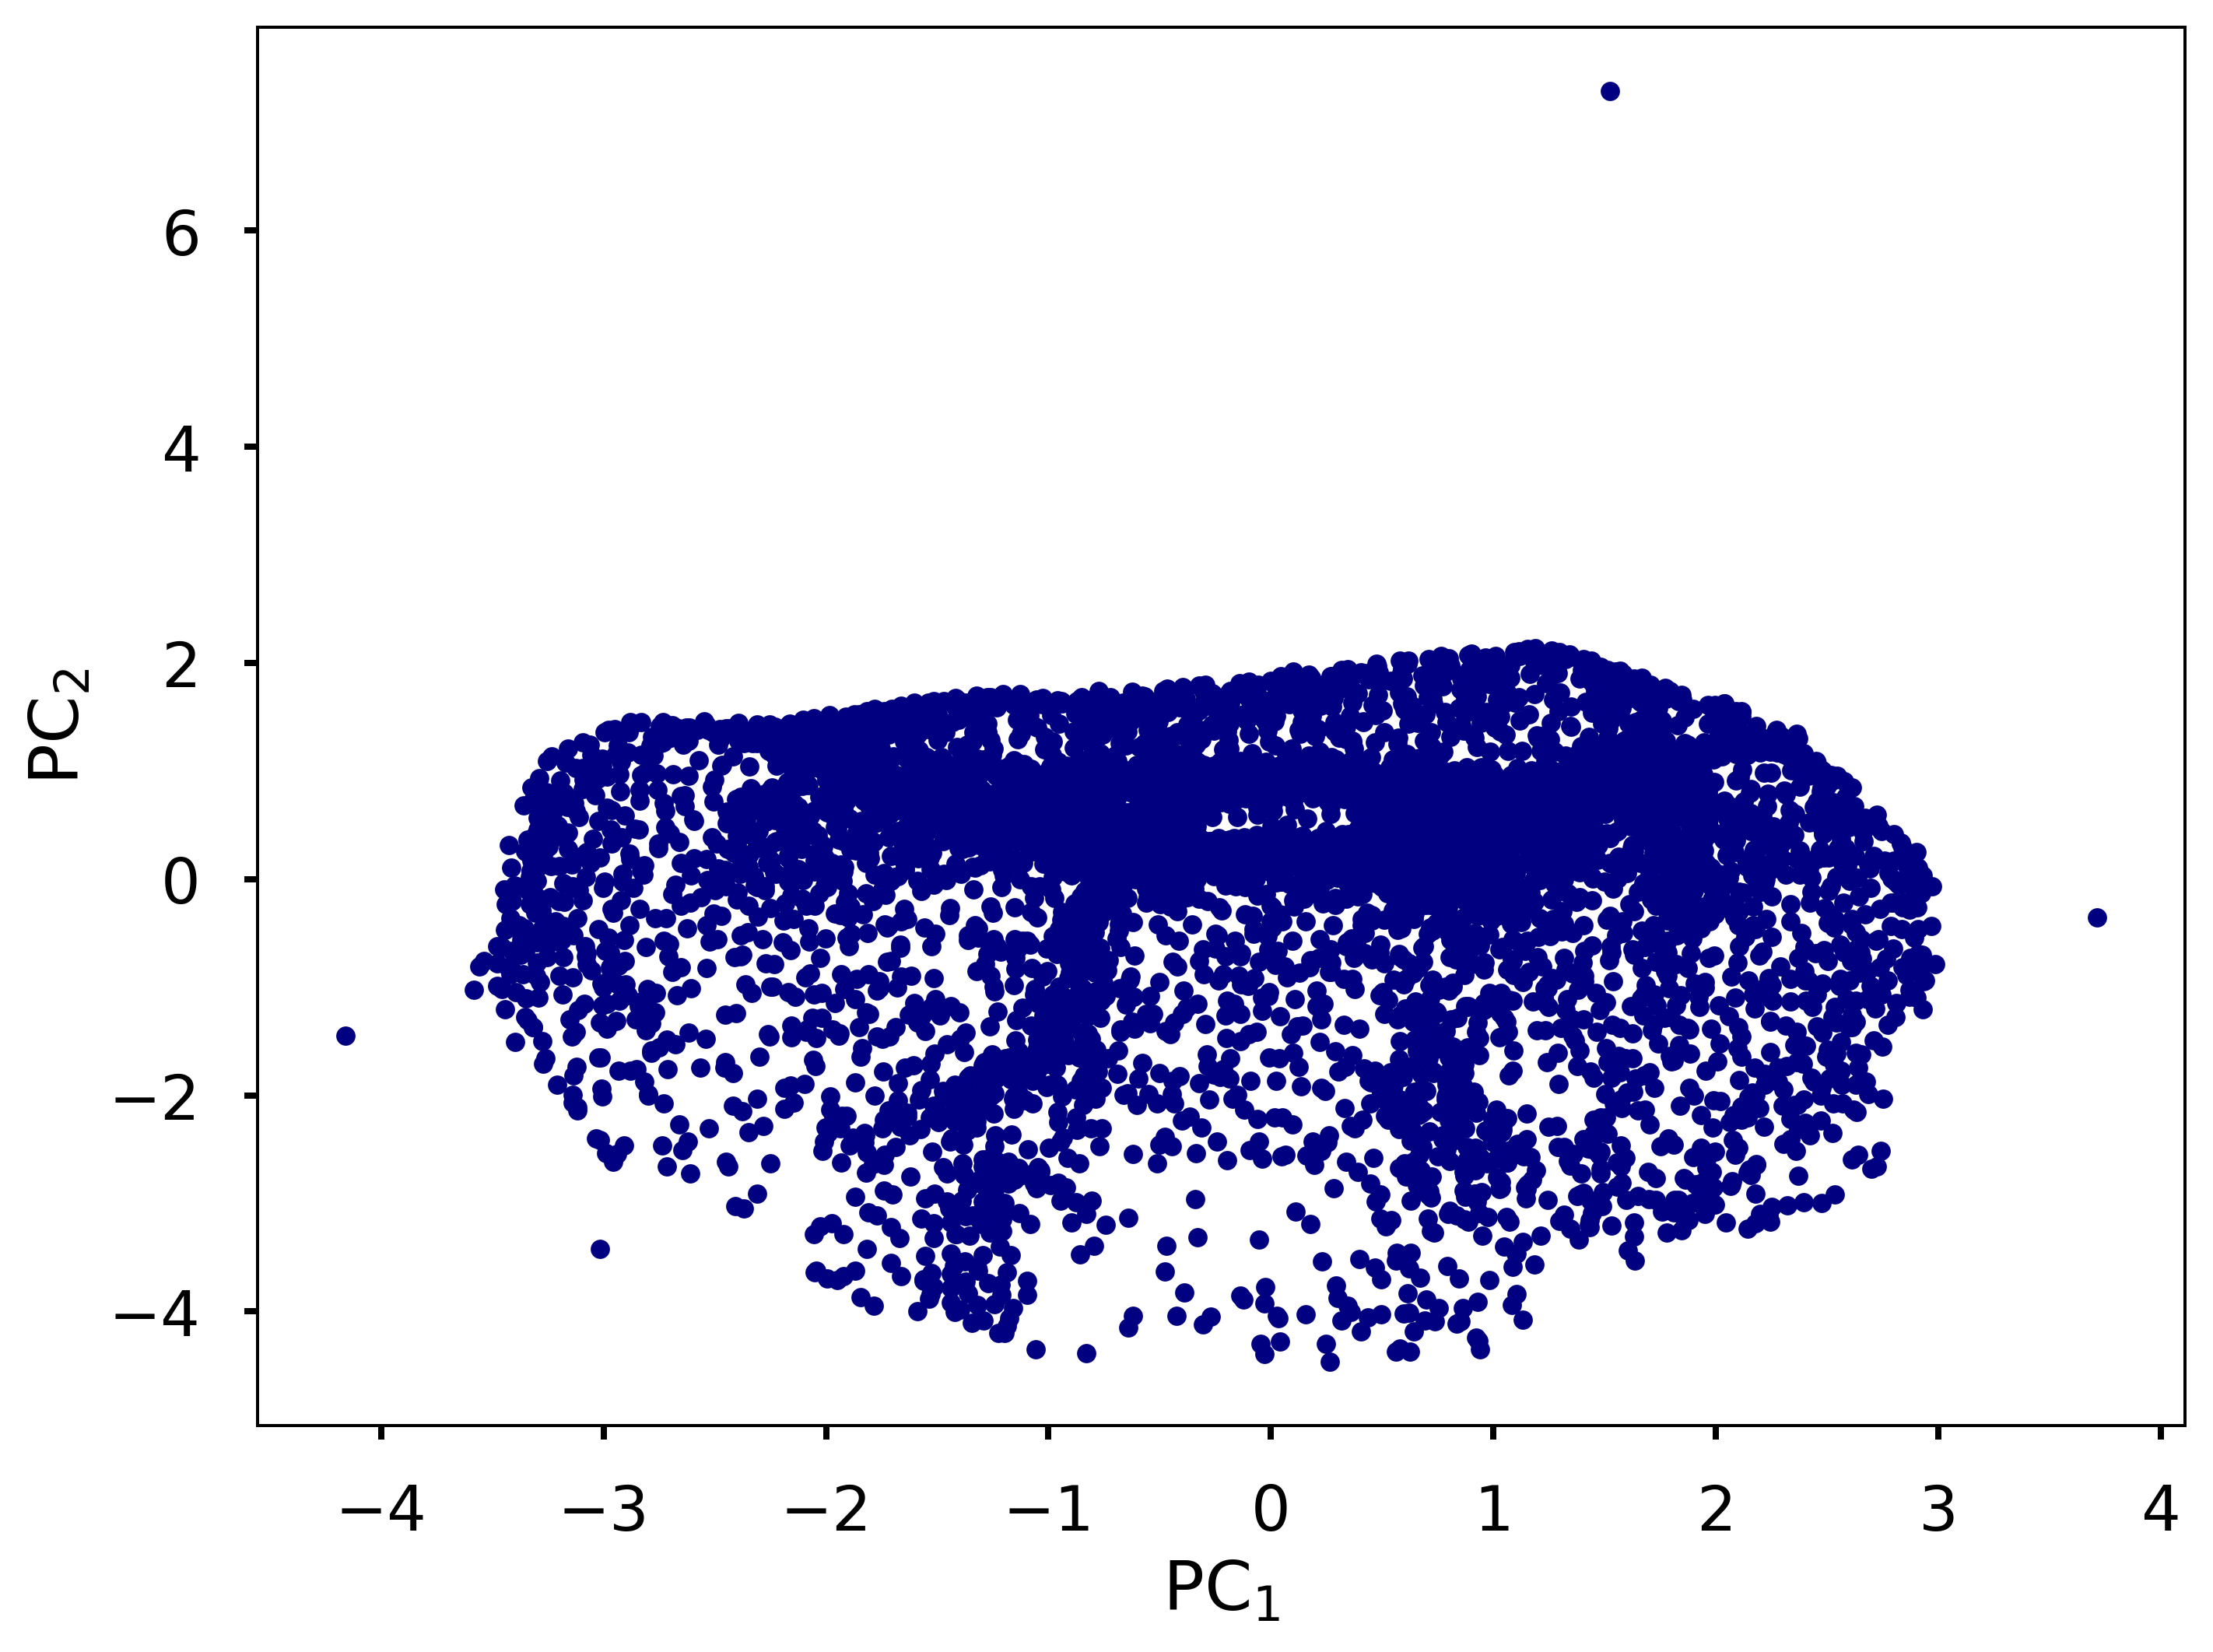

In [148]:
# plot the latent space by PCA

fig, ax = plt.subplots()
p.plot_2d(Yn)

filename = shape_name_string + ' 2D PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

# BGPLVM

In [149]:
max_nr_of_data_points = 5000 #use this line to subsample
max_nr_of_data_points = Y.shape[0]
Y = Y[np.random.choice(Y.shape[0], max_nr_of_data_points, replace=False), :] #permutation on the datapoints
print(Y.shape)

points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)


plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = points[:, 2])
ax.set_title('Points in training')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' points in training.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [150]:
max_nr_of_iters = 20000

init='PCA'
#init='random'

likelihood_variance = 1e-4
likelihood_variance_fix = False #use this to fix the noiselevel

optimizer = 'scg'
optimizer = 'lbfgs'
#optimizer = 'tnc'

num_restarts = 3

input_dim = 7 #Y.shape[1]
num_inducing = 20

In [151]:
k_GPLVM = GPy.kern.RBF(input_dim, ARD = True)

m_GPLVM = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing)

if likelihood_variance_fix:
  m_GPLVM.likelihood.variance = likelihood_variance
  m_GPLVM.likelihood.variance.fix()

m_GPLVM.optimize_restarts(messages=1, num_restarts=num_restarts, max_iters=max_nr_of_iters, optimizer = optimizer) 
print(m_GPLVM) 

Optimization restart 1/3, f = -43118.58523281703


Optimization restart 2/3, f = 29030.15136095075


Optimization restart 3/3, f = 29030.150545333236

Name : bayesian gplvm
Objective : -43118.58523281703
Number of Parameters : 89133
Number of Optimization Parameters : 89133
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (6356, 7)  |               |        
  latent_space.variance    |               (6356, 7)  |      +ve      |        
  inducing_inputs          |                 (20, 7)  |               |        
  rbf.variance             |     0.01745257709802139  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00018708282584389973  |      +ve      |        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

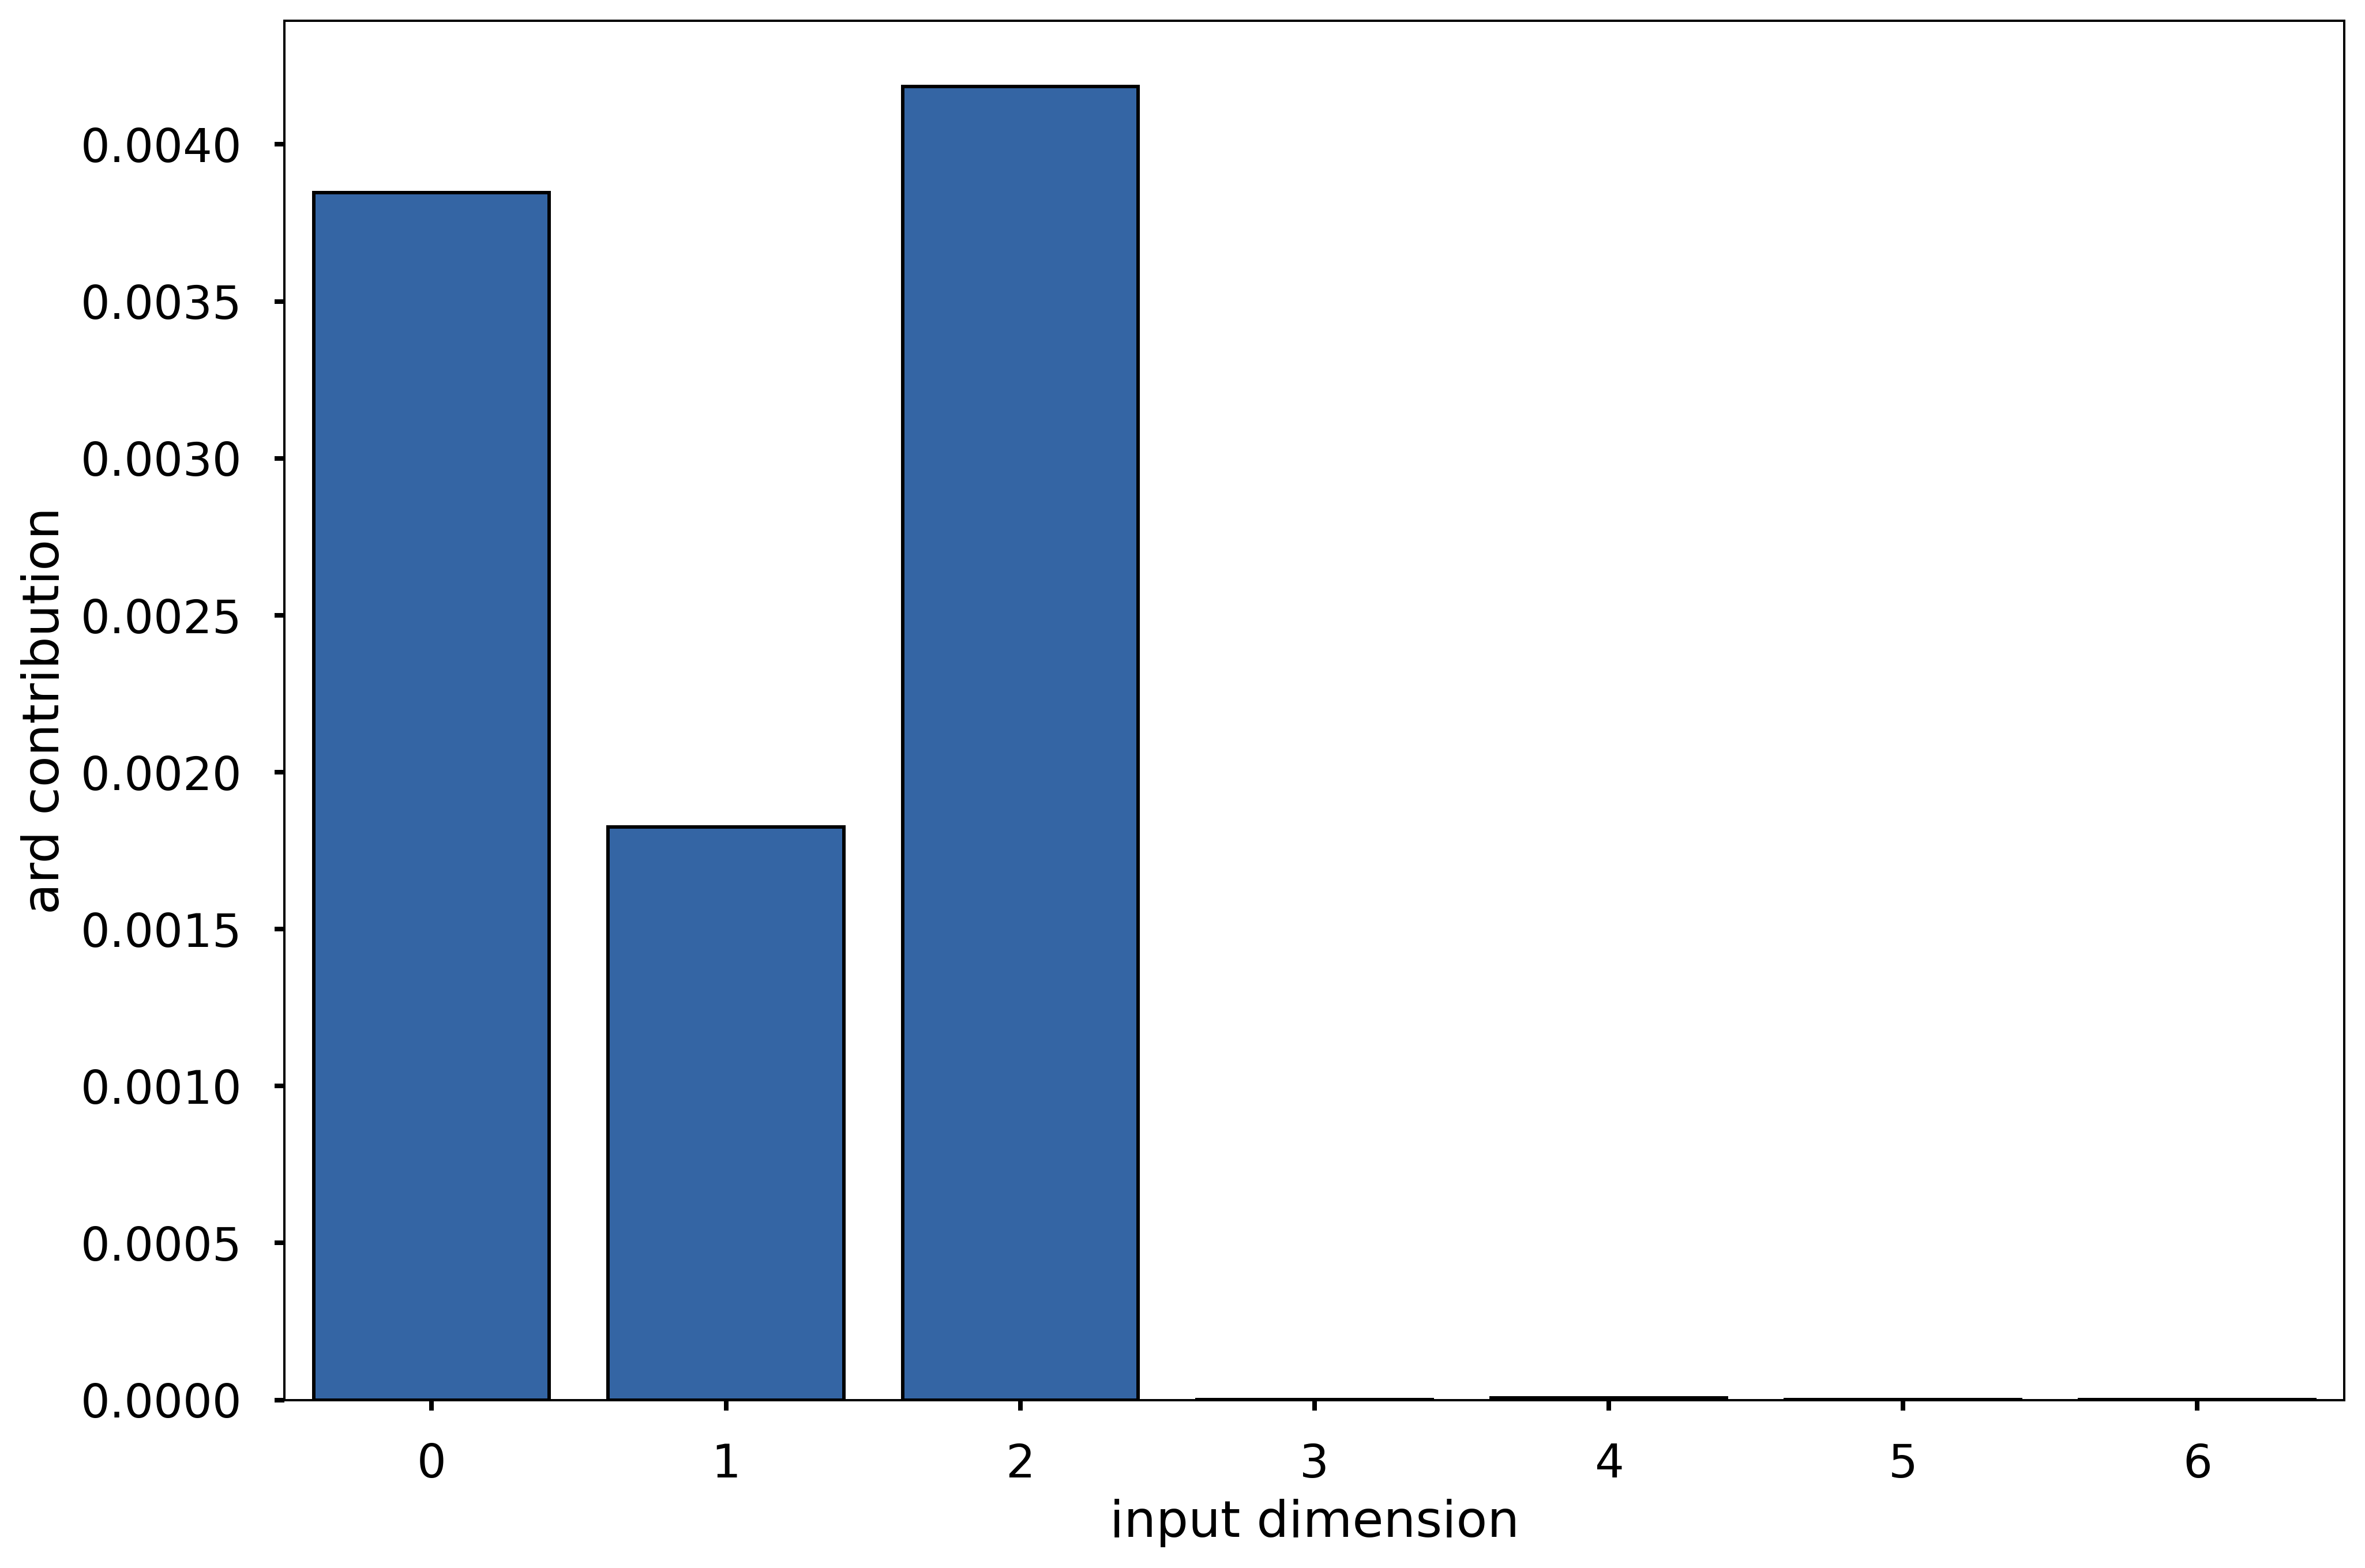

In [152]:
fig, ax = plt.subplots()
m_GPLVM.kern.plot_ARD(ax=ax)

filename = shape_name_string + ' ARD.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [153]:
m_GPLVM.kern.lengthscale #which is the inverse of ARD contribution

index,bayesian_gplvm.rbf.lengthscale,constraints,priors
[0],2.13001045,+ve,
[1],3.09148344,+ve,
[2],2.04206731,+ve,
[3],223.93068049,+ve,
[4],51.78669193,+ve,
[5],226.25477284,+ve,
[6],226.33983217,+ve,


In [154]:
lengthscales = m_GPLVM.kern.lengthscale.argsort()
input_dimension_1 =lengthscales[0]
input_dimension_2 =lengthscales[1]
input_dimension_3 =lengthscales[2]

print(input_dimension_1)
print(input_dimension_2)
print(input_dimension_3)

2
0
1


In [155]:
latent = m_GPLVM.X.mean 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

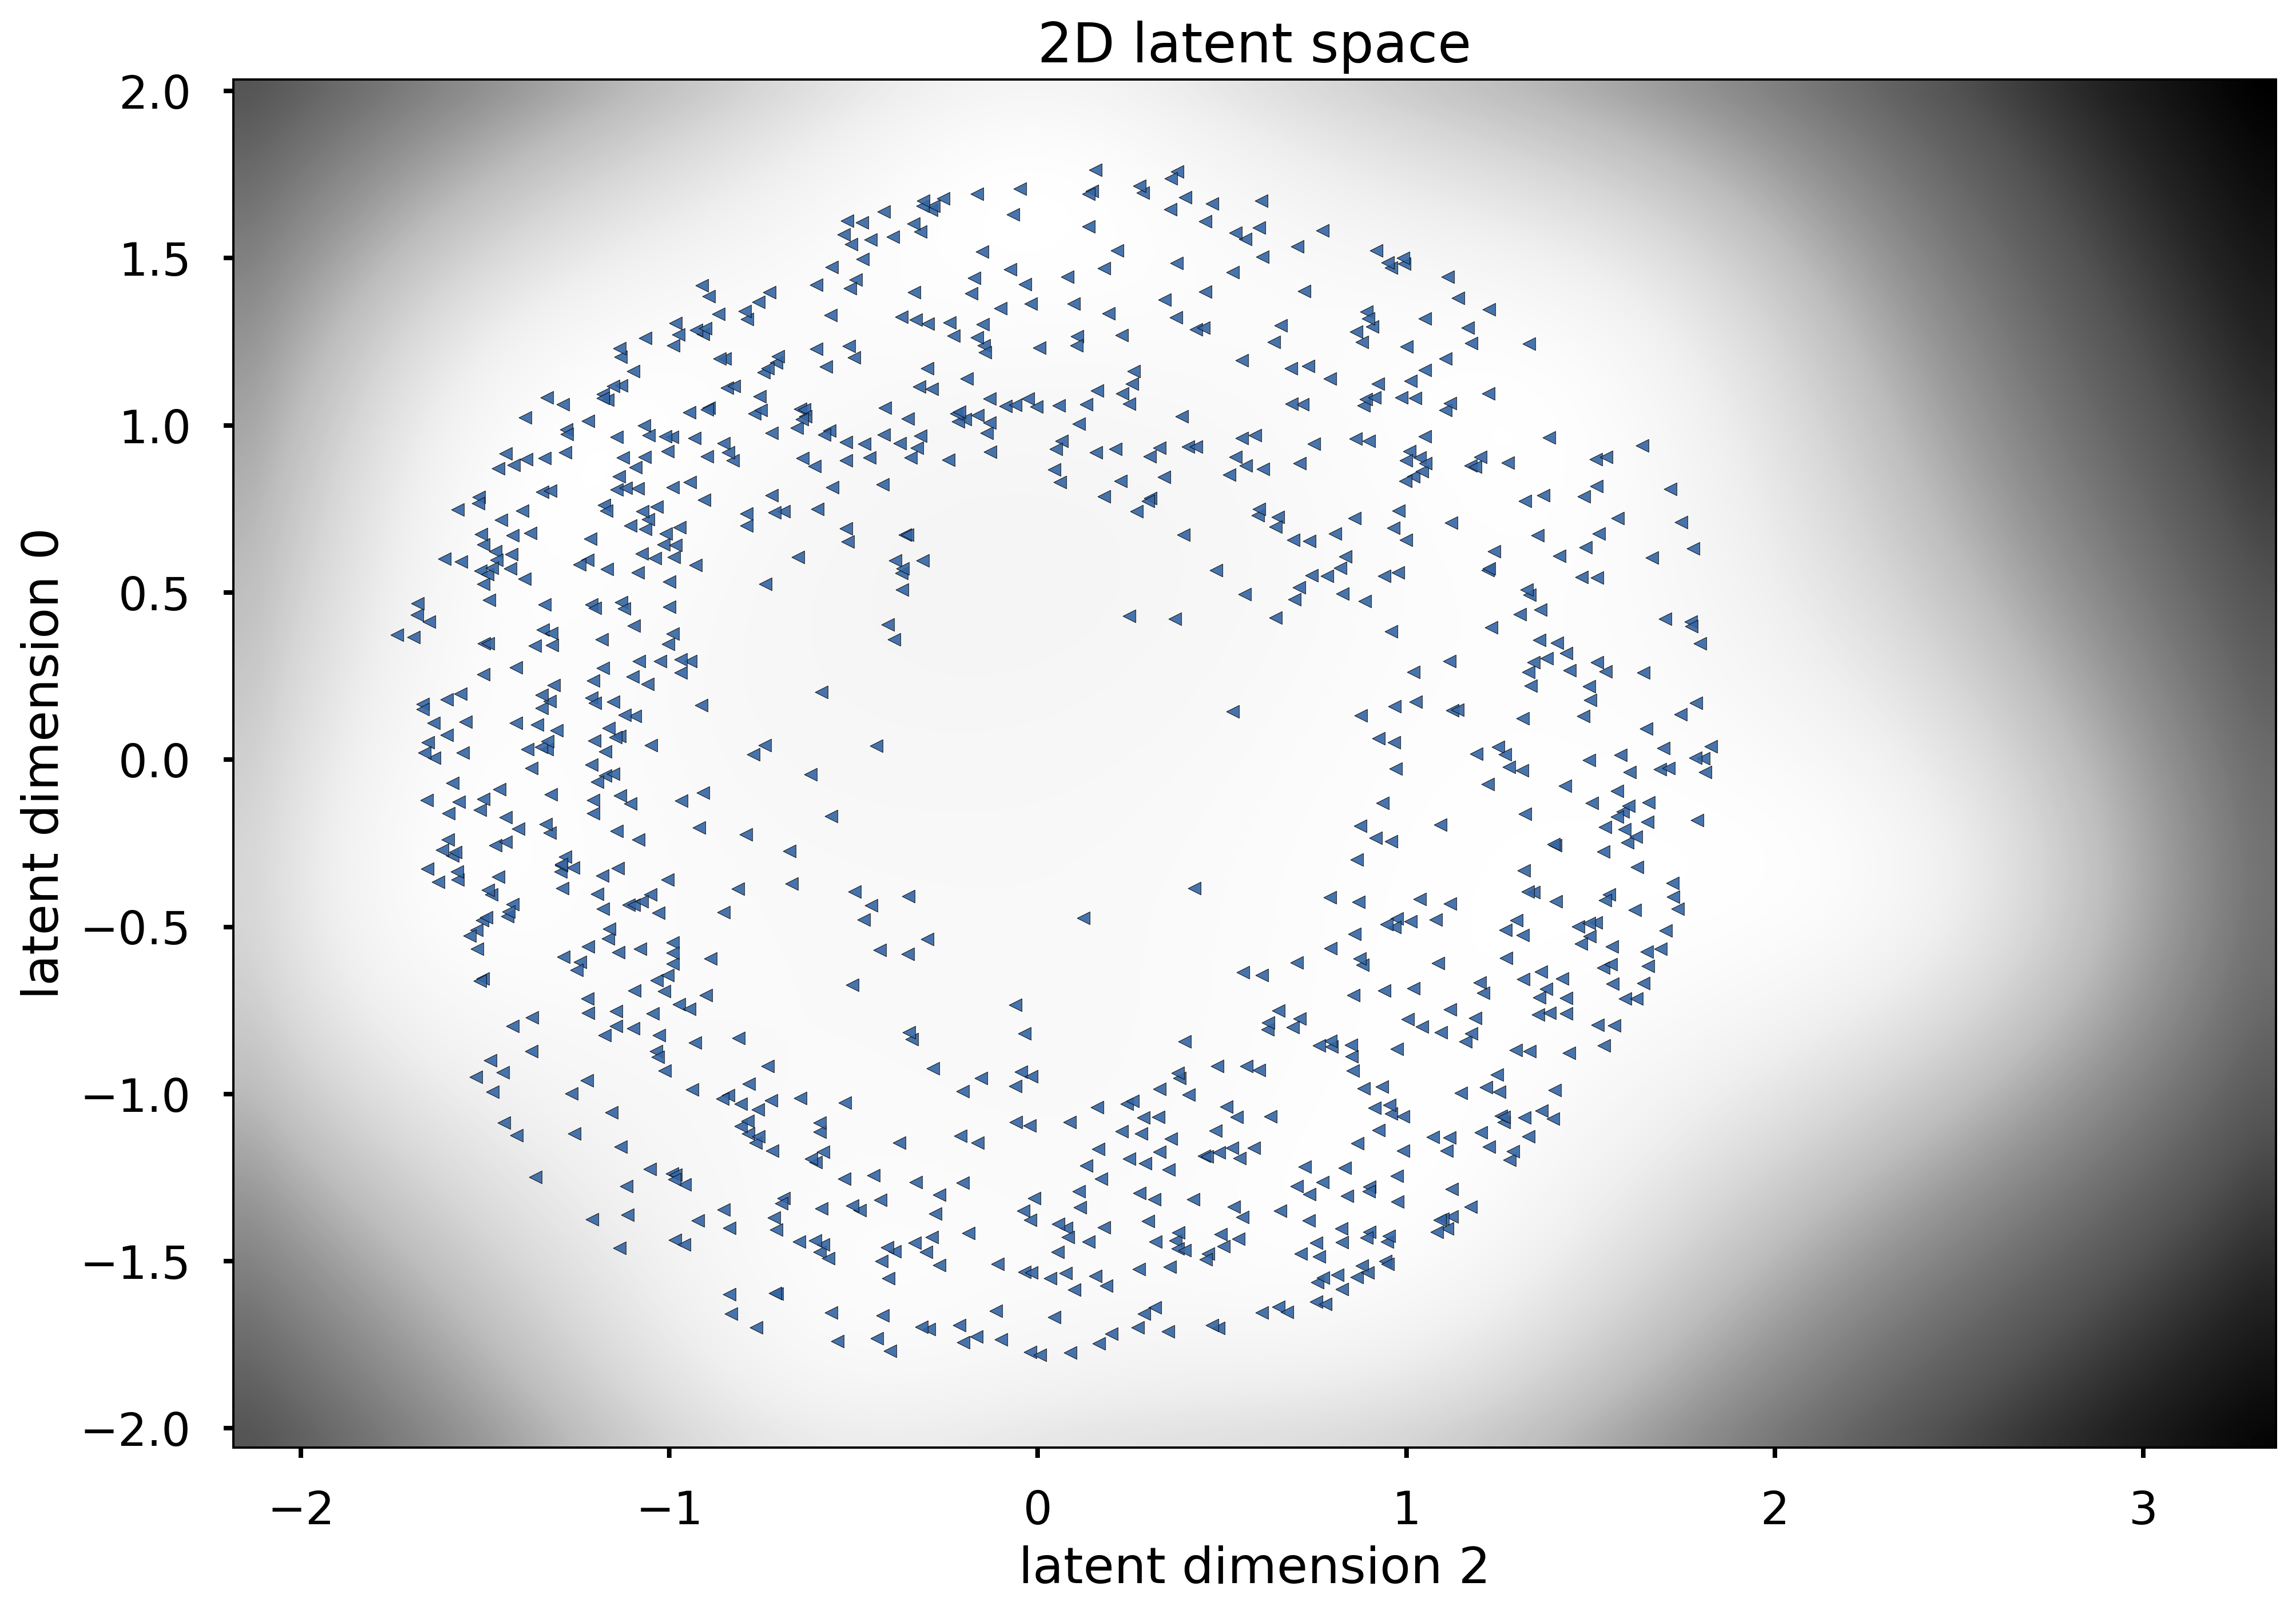

In [156]:
# m_GPLVM.plot_latent(updates=False, legend =True, resolution=100)

fig, ax = plt.subplots()
ax.set_title('2D latent space')
labels = Y
m_GPLVM.plot_latent(ax=ax, updates=False, legend =True)
filename = shape_name_string + ' 2D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [157]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=latent[:, 2], y=latent[:,3], z=latent[:, 0],
                                   mode='markers',
                                   marker=dict(size=2, colorscale='Spectral',opacity=0.8)
                                   )])
fig.show()

In [158]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(latent[:, input_dimension_1], latent[:,input_dimension_2], latent[:, input_dimension_3], c = latent[:, 2])
ax.set_title('3D latent space')

# Set axes label
ax.set_xlabel('input dimension ' + str(input_dimension_1), labelpad=20)
ax.set_ylabel('input dimension ' + str(input_dimension_2), labelpad=20)
ax.set_zlabel('input dimension ' + str(input_dimension_3), labelpad=20)

filename = shape_name_string + ' 3D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)



Output hidden; open in https://colab.research.google.com to view.

#Save/load the model

In [159]:
# 1: Saving a model:
filename = shape_name_string + ' BGPLVM.npy'
np.save(filename, m_GPLVM.param_array)
files.download('/content/' + filename)
print(m_GPLVM)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Name : bayesian gplvm
Objective : -43118.58523281703
Number of Parameters : 89133
Number of Optimization Parameters : 89133
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (6356, 7)  |               |        
  latent_space.variance    |               (6356, 7)  |      +ve      |        
  inducing_inputs          |                 (20, 7)  |               |        
  rbf.variance             |     0.01745257709802139  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00018708282584389973  |      +ve      |        


In [160]:
# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(filename) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)


Name : bayesian gplvm
Objective : -43118.58523281703
Number of Parameters : 89133
Number of Optimization Parameters : 89133
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (6356, 7)  |               |        
  latent_space.variance    |               (6356, 7)  |      +ve      |        
  inducing_inputs          |                 (20, 7)  |               |        
  rbf.variance             |     0.01745257709802139  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00018708282584389973  |      +ve      |        
